In [6]:
import os
import sys
sys.path.append('../')
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim
from dataset import Galaxy_Dataset, get_COSMOS_Galaxy, get_LSST_PSF
from models.Wiener import Wiener
from models.Richard_Lucy import Richard_Lucy
from models.Unrolled_ADMM import Unrolled_ADMM, InitNet, ResUNet
from utils.utils import PSNR, estimate_shear

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = Unrolled_ADMM(n_iters=8, llh='Poisson', PnP=True)
total = sum([param.nelement() for param in model.parameters()])
print(total)

model = InitNet(n=8)
total = sum([param.nelement() for param in model.parameters()])
print(total)

model = ResUNet()
total = sum([param.nelement() for param in model.parameters()])
print(total)

17087980
80236
17007744


### Define basic parameters

In [8]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 48
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

OSError: /mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/real_galaxy_catalog_23.5.fits not found.

### Simulate PSF

In [ ]:
rng = galsim.UniformDeviate(seed=19) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
# PSF parameters
atmos_fwhm = 0.7 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
# atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_e = 0.6 * atmos_max_shear
# atmos_beta = 2. * np.pi * rng()     # radians
atmos_beta = 2. * np.pi * 0.5     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

psf = get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                    atmos_fwhm, atmos_e, atmos_beta, 0, 0,
                    fov_pixels, pixel_scale=pixel_scale) 
psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

### Simulate galaxy

In [ ]:
idx = 245 # index pf galaxy in the catalog

# Galaxy parameters 
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_shear = galsim.Shear(e=gal_e, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
sky_level = 1.e3                     # ADU / arcsec^2
dx, dy = rng() - 0.5, rng() - 0.5

snr_list = [100, 50, 20, 10]
# gal_flux_list = [6.25e4, 2.5e4, 1e4, 0.75e4, 0.4e4]
gal_flux_list = []
gt_list, gt_shear_list = [], []
for snr in snr_list:  
    gal_flux = (snr**2) * (1 + np.sqrt(1 + 8*sky_level*(fov_pixels**2)*(pixel_scale**2)/(snr**2)))/2
    gal_flux_list.append(gal_flux)
    gt, gal_orig = get_COSMOS_Galaxy(catalog=real_galaxy_catalog, idx=idx, 
                                     gal_flux=gal_flux, sky_level=sky_level, 
                                     gal_e=gal_e, gal_beta=gal_beta, 
                                     theta=theta, gal_mu=gal_mu, dx=dx, dy=dy, 
                                     fov_pixels=fov_pixels, pixel_scale=pixel_scale)
    gt_list.append(gt)
    gt_shear_list.append(estimate_shear(gt.numpy(),psf_delta)[2])
    # snr = gal_flux/np.sqrt(gal_flux + sky_level*(fov_pixels**2)*(pixel_scale**2))
    # snr_list.append(snr)
    print('gal_flux={:.1f} \tSNR={:.1f}'.format(gal_flux, snr))


gal_flux=48222.7 	SNR=100.0
gal_flux=22752.6 	SNR=50.0
gal_flux=8788.8 	SNR=20.0
gal_flux=4343.5 	SNR=10.0


### Simulate Observation

In [ ]:
obs_list, obs_ori_list = [], []
for gt in gt_list:
    # Convolution via FFT
    conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).real
    conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

    # Add CCD noise (Poisson + Gaussian)
    obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
    obs_ori = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
    obs = (obs_ori - obs_ori.min())/(obs_ori.max() - obs_ori.min())

    obs_list.append((obs, estimate_shear(obs.numpy(),psf_delta)[2], PSNR(obs,gt)))
    obs_ori_list.append(obs_ori)

### Wiener Deconvolution

In [ ]:
rec_wiener = []
for (obs,_,_), snr in zip(obs_list, snr_list):
    rec = fftshift(ifft2(fft2(obs) / fft2(psf) / (1+1/(fft2(psf).abs()**2 * snr)) )).real
    rec_wiener.append((rec, estimate_shear(rec.numpy(),psf_delta)[2], PSNR(rec,gt)))

### Richardson-Lucy Deconvolution

In [ ]:
iter_list = [20,100]

rec_RL = [[], []]
for idx, n_iters in enumerate(iter_list):
    model = Richard_Lucy(n_iters=n_iters)
    model.to(device)
    model.eval()
    for (obs,_,_), gal_flux, obs_ori in zip(obs_list, gal_flux_list, obs_ori_list):
        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
        rec = output.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
        rec_shear = estimate_shear(rec,psf_delta)[2]
        rec_psnr = PSNR(rec,gt)
        rec = np.where(rec>0,rec,0)
        # rec_img = rec/rec.sum() * (gal_flux + sky_level*(pixel_scale**2)*(fov_pixels**2))
        rec_img = rec/rec.max()*obs_ori.numpy().max()
        rec_RL[idx].append((rec_img, rec_shear, rec_psnr))

### Unrolled ADMM

In [ ]:
iter_list = [1,4]
rec_admm = [[], []]
model_files = ['saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth', 
               'saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM(n_iters=n_iters, llh='Poisson', PnP=True)
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for (obs,_,_), gal_flux, obs_ori in zip(obs_list, gal_flux_list, obs_ori_list):
        alpha = obs.ravel().mean()/0.33
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = (output.cpu() * alpha.cpu()).squeeze(dim=0).squeeze(dim=0).detach().numpy()
        rec_shear = estimate_shear(rec,psf_delta)[2]
        rec_psnr = PSNR(rec,gt)
        rec = np.where(rec>0,rec,0)
        # rec_img = rec/rec.sum() * (gal_flux + sky_level*(pixel_scale**2)*(fov_pixels**2))
        rec_img = rec/rec.max()*obs_ori.numpy().max()
        rec_admm[idx].append((rec_img, rec_shear, rec_psnr))

Successfully loaded in saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth.


### Grid Plot

[tensor(490.7126), 490.71262, 490.71262, 490.71262, 490.71262]
[tensor(15.5255), 2.2046373, 0.14258792, 5.552283, 23.639156]
[tensor(145307.0156), 70055.31, 64775.96, 55753.977, 84472.09]
490.71262
[tensor(272.7930), 272.79297, 272.79297, 272.79297, 272.79297]
[tensor(20.1713), 3.686206, 0.26376247, 5.0822954, 10.492009]
[tensor(117254.3906), 49439.742, 38926.234, 27512.236, 36421.59]
272.79297
[tensor(135.1857), 135.18567, 135.18567, 135.18567, 135.18567]
[tensor(17.7709), 6.240094, 0.36436838, 8.348001, 9.188248]
[tensor(101379.0781), 49109.742, 34861.195, 29743.695, 29707.404]
135.18567
[tensor(84.9371), 84.93714, 84.93714, 84.93714, 84.93714]
[tensor(19.6015), 7.306067, 0.81740695, 5.898629, 8.71694]
[tensor(96036.7344), 45399.83, 35584.953, 25025.002, 27097.129]
84.93714


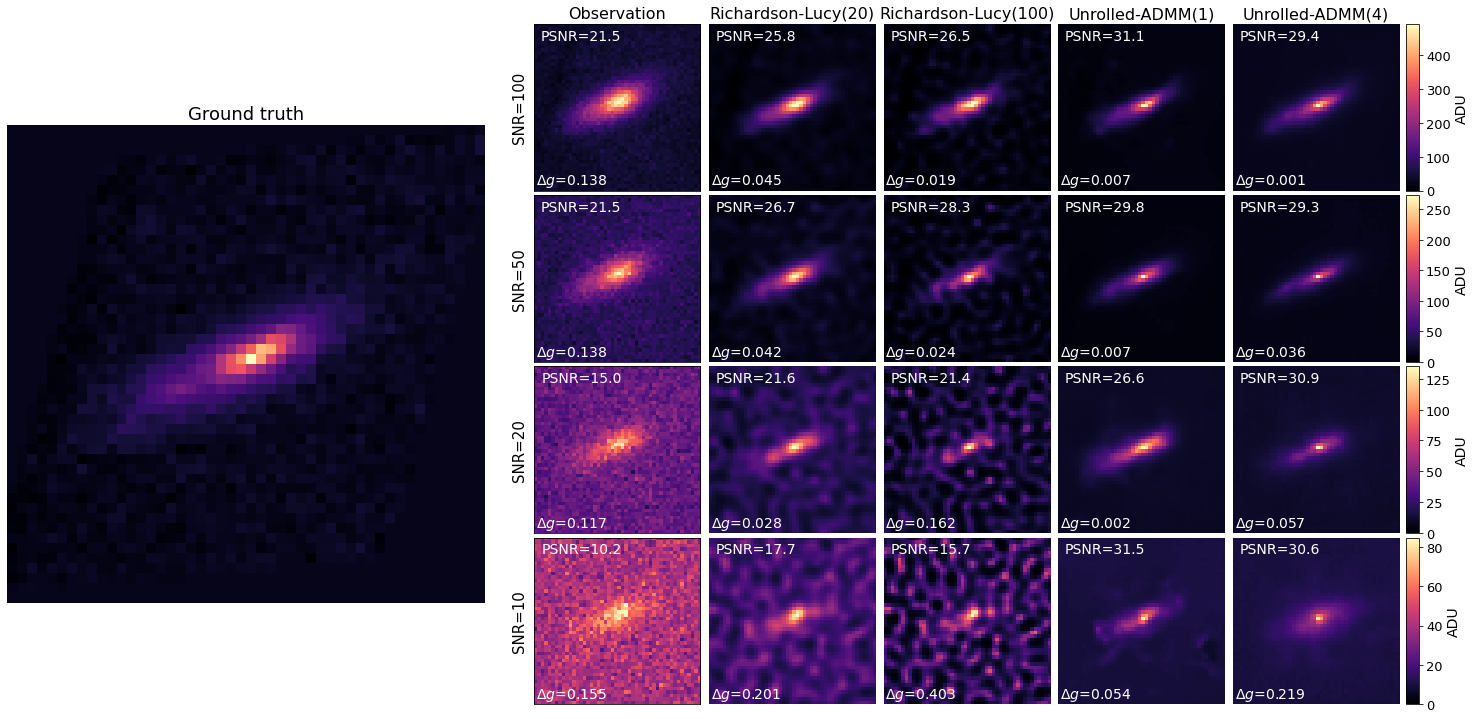

In [ ]:
fig = plt.figure(figsize=(25,12.5), facecolor='white')
ax = plt.gca()
gs = gridspec.GridSpec(8, 32)
cmap = 'magma'

plt.subplot(gs[1:7,0:11])
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.imshow(gt, cmap=cmap)
plt.axis('off')
plt.title('Ground truth', fontsize=18)
        
for idx, (snr, obs, obs_ori, gt_shear, rec_RL_20, rec_RL_100, rec_1, rec_4) in enumerate(zip(snr_list, obs_list, obs_ori_list, gt_shear_list, rec_RL[0], rec_RL[1], rec_admm[0], rec_admm[1])):
    vmax = np.max([obs_ori.max(), rec_RL_20[0].max(), rec_RL_100[0].max(), rec_1[0].max(), rec_4[0].max()])
    # vmin = np.max([obs_ori.min(), rec_RL_20[0].min(), rec_RL_100[0].min(), rec_1[0].min(), rec_4[0].min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=0)
    
    
    ax2 = plt.subplot(gs[2*idx:2*idx+2,12:16])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(obs_ori, cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(obs[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(obs[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.ylabel("SNR={:.0f}".format(snr), fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    if idx == 0:
        plt.title('Observation', fontsize=16)


    ax4 = plt.subplot(gs[2*idx:2*idx+2,16:20])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_20[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_RL_20[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_RL_20[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Richardson-Lucy(20)', fontsize=16)


    ax5 = plt.subplot(gs[2*idx:2*idx+2,20:24])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_100[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_RL_100[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_RL_100[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Richardson-Lucy(100)', fontsize=16)


    ax6 = plt.subplot(gs[2*idx:2*idx+2,24:28])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_1[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_1[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_1[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM(1)', fontsize=16)


    ax7 = plt.subplot(gs[2*idx:2*idx+2,28:32])
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_4[0], cmap=cmap, norm=norm)
    plt.title("PSNR={:.1f}".format(rec_4[2]),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(rec_4[1]-gt_shear)),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM(4)', fontsize=16)
    cax = fig.add_axes([ax7.get_position().x1+4e-3,ax7.get_position().y0,7e-3,ax7.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=13)
    cb.set_label('ADU',fontsize=14)
    
plt.savefig('grid.eps', bbox_inches='tight')